# Financial Model Engineering using Python

In this Project, our goal is to make use of 12 financial instruments and create a portfolio consisting of 
1. **5 out of the 6 Stocks (AAPL, AMZN, ATT, GE, INTC, LEHM)**
2. **1 out of the 2 Index bond (FBNDX, SPY)**
3. **1 out of the 2 Commodity instruments (GOLD, SILVER)**
4. **1 out of the 2 Currency instruments (AUD, EUR)**

The portfolio is created in such a way that the adjusted return to risk ratio can be maximized using advanced analysis techniques like Moving Average Convergence Divergence (MACD) and Relative Strength Index (RSI), to identify market trends and generate trading signals.

In [1]:
#Import libraries that'll be used for creating our portfolio
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
from itertools import product
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

#Setting up aspect ratio if plotting inline
aspect_ratio = (12, 8)
annualization_factor=260

Let's define few functions that we will reuse until we find the optimal portfolio

The function `movingAverageCrossover` provides a flexible framework for testing Moving Average Crossover strategies on various price data. It takes the data frame containing all the prices, fast window, and slow window values. It implements going flat and going short on the given data and returns a data frame with benchmark values, MA short and MA long values.

In [3]:
#Function to calculate MA crossover strategies
def movingAverageCrossover(data, fastWindow, slowWindow):
    df = data.copy()
    
    #Check if the DataFrame has more than one column
    if df.shape[1] != 1:
        raise ValueError("Input DataFrame must have exactly one column")
    
    #Get the instrument name
    instrumentName = df.columns[0]
    
    #Calculate fast and slow SMAs
    df['FastSMA'] = df[instrumentName].rolling(fastWindow).mean()
    df['SlowSMA'] = df[instrumentName].rolling(slowWindow).mean()
    
    #Drop null values
    df.dropna(inplace=True)
    
    #Calculate log returns
    df['BMKReturns'] = np.log(df[instrumentName] / df[instrumentName].shift(1))
    
    #SMA strategy: if rising trend, stay long, otherwise go flat
    df['PositionFlat'] = np.where(df['FastSMA'] > df['SlowSMA'], 1, 0)
    
    #SMA strategy: if rising trend, stay long, otherwise go short
    df['PositionShort'] = np.where(df['FastSMA'] > df['SlowSMA'], 1, -1)
    
    #Calculate the strategy returns, taking care to push down the Position column
    df['MAFlatReturns'] = df['PositionFlat'].shift(1) * df['BMKReturns']
    df['MAShortReturns'] = df['PositionShort'].shift(1) * df['BMKReturns']
    
    #Create the result DataFrame
    result = pd.DataFrame({
        f'{instrumentName}-BMK-MA': df['BMKReturns'],
        f'{instrumentName}-MAFlat': df['MAFlatReturns'],
        f'{instrumentName}-MAShort': df['MAShortReturns']
    })
    
    return result

The function `Bollinger bands` provides a flexible framework for testing Bollinger strategies on various price data. It takes the data frame containing all the prices, look back window, and the number of standard deviations. It calculated the upper band and the lower bands on the given data and returns a data frame with benchmark values and Bollinger band returns.

In [4]:
#Function for applying bollinger band strategy using different parameters
def bollingerBands(dataframe, lookbackWindow, stdevBand):
    df = dataframe.copy()
    # Check if the DataFrame has more than one column
    if df.shape[1] != 1:
        raise ValueError("Input DataFrame must have exactly one column.")
    
    # Get the instrument name
    instrumentName = df.columns[0]
    
    # Calculate rolling mean and standard deviation
    df['Mean'] = df[instrumentName].rolling(lookbackWindow).mean()
    df['Stdev'] = df[instrumentName].rolling(lookbackWindow).std()
    
    # Drop NaN values
    df.dropna(inplace=True)
    
    # Calculate upper and lower bands
    df['Upper'] = df['Mean'] + stdevBand * df['Stdev']
    df['Lower'] = df['Mean'] - stdevBand * df['Stdev']
    
    # Set initial position based on the first row
    date0 = df.index[0]
    if df.loc[date0, instrumentName] >= df.loc[date0, 'Upper']:
        df.loc[date0, 'Position'] = -1
    elif df.loc[date0, instrumentName] <= df.loc[date0, 'Lower']:
        df.loc[date0, 'Position'] = 1
    else:
        df.loc[date0, 'Position'] = 0
    
    # Loop over data to update positions
    for i in range(1, df.shape[0]):
        today = df.index[i]
        yesterday = df.index[i-1]
        
        if df.loc[today, instrumentName] >= df.loc[today, 'Upper']:
            df.loc[today, 'Position'] = -1
        elif df.loc[today, instrumentName] <= df.loc[today, 'Lower']:
            df.loc[today, 'Position'] = 1
        elif (df.loc[yesterday, 'Position'] == -1 and 
              df.loc[today, instrumentName] <= df.loc[today, 'Mean']):
            df.loc[today, 'Position'] = 0
        elif (df.loc[yesterday, 'Position'] == 1 and 
              df.loc[today, instrumentName] >= df.loc[today, 'Mean']):
            df.loc[today, 'Position'] = 0
        else:
            df.loc[today, 'Position'] = df.loc[yesterday, 'Position']
            
    # Calculate returns
    df['BMKReturns'] = np.log(df[instrumentName] / df[instrumentName].shift(1))
    df['BBReturns'] = df['Position'].shift(1) * df['BMKReturns']
    
    # Create result DataFrame
    result = pd.DataFrame({
        f'{instrumentName}-BMK-BB': df['BMKReturns'],
        f'{instrumentName}-BB': df['BBReturns']

    })
    
    return result

The function `runMovingAverageAndBB` takes in the input of the data frame, fastWindow, slowWindow, lookbackWindow, and stdevBand values calls the two functions - movingAverageCrossover and bollingerBands functions and applies these strategies to the data frame using the input parameters and merges the result of both the function call.

In [5]:
def runMovingAverageAndBB(data, fastWindow, slowWindow, lookbackWindow, stdevBand):
    df = data.copy()
    
    #Apply MA strategy using the function movingAverageCrossover
    maData = movingAverageCrossover(df, fastWindow, slowWindow)
    
    #Apply BB strategy using the function bollingerBands
    bbData = bollingerBands(df, lookbackWindow, stdevBand)
    
    #Merge all the dataset using inner join
    merged_df = pd.merge(maData, bbData, left_index=True, right_index=True)
    merged_df.dropna(inplace=True)
    
    #Return the results
    return merged_df
    

The function `read_price_data()` will read the required CSV file to check for any null values, print its information, and summarize statistics where we can quickly gain valuable insights into its key characteristics, such as central tendency, spread, and the presence of outliers. These statistics provide an understanding of the data’s overall structure and guide further analysis.

In [6]:
#Function to read and check the data
def read_price_data(filename, index_col=0, parse_dates=True):

    # Read the CSV file into a DataFrame
    df = pd.read_csv(filename, index_col=index_col, parse_dates=parse_dates)

    # Print DataFrame info
    print("DataFrame Information")
    print(df.info())

    # Check for null values
    print("Null Values in DataFrame")
    print(df.isnull().sum())

    # Print summary statistics
    print("Summary Statistics")
    print(df.describe())

    # Display the DataFrame
    print("DataFrame Contents")
    print(df)

    # Return the DataFrame
    return df

In [7]:
#Load data using read_price_data function
dfPrices = read_price_data('PricesProjectA.csv', index_col=0, parse_dates=True)

DataFrame Information
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4745 entries, 1999-12-31 to 2018-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    4745 non-null   float64
 1   AMZN    4745 non-null   float64
 2   ATT     4745 non-null   float64
 3   AUD     4745 non-null   float64
 4   EUR     4745 non-null   float64
 5   FBNDX   4745 non-null   float64
 6   GE      4745 non-null   float64
 7   GOLD    4745 non-null   float64
 8   INTC    4745 non-null   float64
 9   LEHM    4745 non-null   float64
 10  SILVER  4745 non-null   float64
 11  SPY     4745 non-null   float64
dtypes: float64(12)
memory usage: 481.9 KB
None
Null Values in DataFrame
AAPL      0
AMZN      0
ATT       0
AUD       0
EUR       0
FBNDX     0
GE        0
GOLD      0
INTC      0
LEHM      0
SILVER    0
SPY       0
dtype: int64
Summary Statistics
              AAPL         AMZN          ATT          AUD          EUR  \
count  4745.

In [8]:
#Verify the start date
dfPrices.iloc[0]

AAPL        0.917969
AMZN        3.806250
ATT        36.820244
AUD         0.656700
EUR         1.006200
FBNDX       6.890000
GE        396.794861
GOLD      288.000000
INTC       41.156250
LEHM      798.154631
SILVER      5.380000
SPY       146.875000
Name: 1999-12-31 00:00:00, dtype: float64

In [9]:
#Verify the end date
dfPrices.iloc[-1]

AAPL        39.435001
AMZN        75.098503
ATT         21.555891
AUD          0.704900
EUR          1.146700
FBNDX        7.670000
GE          58.230770
GOLD      1282.490000
INTC        46.930000
LEHM      1000.995080
SILVER      15.495000
SPY        249.919998
Name: 2018-12-31 00:00:00, dtype: float64

## Sensitivity Analysis

We conducted a sensitivity analysis to estimate the maximum Sharpe ratio for various trading strategies. The strategies examined include Moving Average (MA) FLAT, MA SHORT, Bollinger Bands (BB), and LOG RETURNS.

We used:
* fastWindow Range between 5 to 110
* slowWindow Range between 50 to 500 with five increments 
* lookbackWindow Range between 5 to 50
* stdevBand Range between 1 to 4

The goal was to identify which combination of parameters yielded the highest Sharpe ratio, providing insights into the optimal configurations for each strategy.

**The final results with maximum sharpe ratio for different strategies and the parameters:**
 
| Category       | Asset   | AAPL | AMZN | ATT  | INTC | SPY  | GE   | AUD | EUR | FBNDX | LEHM | SILVER | GOLD |
|----------------|---------|------|------|------|------|------|------|-----|-----|-------|------|--------|------|
| MA FLAT        | SHARPE  | 1.03 | 0.81 | 0.27 | 0.22 | 0.66 | 0.23 | 0.42| 0.49| 0.58  | 0.49 | 0.5    | 0.69 |
|                | FW      | 5    | 109  | 100  | 62   | 30   | 96   | 107 | 80  | 22    | 5    | 84     | 56   |
|                | SW      | 240  | 250  | 425  | 215  | 220  | 100  | 115 | 90  | 105   | 145  | 115    | 480  |
| MA SHORT       | SHARPE  | 0.79 | 0.56 | 0.38 | 0.29 | 0.58 | 0.57 | 0.48| 0.55| 0.67  | 0.45 | 0.53   | 0.71 |
|                | FW      | 51   | 109  | 98   | 60   | 30   | 87   | 107 | 80  | 68    | 5    | 84     | 56   |
|                | SW      | 55   | 240  | 430  | 80   | 220  | 350  | 115 | 90  | 125   | 145  | 115    | 480  |
| BB             | SHARPE  | 0.16 | 0.44 | 0.63 | 0.6  | 0.67 | 0.12 | 0.09| 0.44| 0.19  | 0.25 | 0.34   |      |
|                | LOOKBACK| 3    | 26   | 9    | 4    | 8    | 48   | 32  | 25  | 3     | 55   | 34     | 24   |
|                | SD      | 1    | 3    | 1    | 1    | 1    | 3    | 3   | 3   | 1     | 3    | 3      | 3    |
| LOG RETURNS    | SHARPE  | 0.48 | 0.3  | -0.11| 0.03 | 0.07 | 0.15 | -0.33| 0.46 | 0.02 | 0.33   | 0.19 | 0.15 |

From these values, we have chosen eight instruments:
* Apple - AAPL
* Amazon - AMZN
* AT&T - ATT
* General Electric - GE
* Intel - INTC
* Fidelity Investment Grade Bond Index  - FBNDX
* Gold - GOLD
* Euro - EUR


## Portfolio Strategy

Choice of Strategy:
* AAPL - MA Flat
* AMZN - MA Flat
* ATT - Bollinger Band
* GE - MA Short
* INTC - Bollinger Band
* FBNDX - MA Short
* GOLD - MA Short
* EUR - MA Short

Choice of Parameters:
* maFast = 51
* maSlow = 109
* bbWindow = 240
* bbStdevBand = 3

## Parameters for MA and BB Strategy

In [ ]:
#Parameters chosen
maFast = 51
maSlow = 109
bbWindow = 240
bbStdevBand = 3
myStrategies = ['AAPL-MAFlat', 'AMZN-MAFlat', 'ATT-BB', 'GE-MAShort', 'INTC-BB', 'FBNDX-MAShort', 'GOLD-MAShort', 'EUR-MAShort']

#### Master dataframe


In [10]:
#All the instruments labels
instruments = ['AAPL', 'AMZN', 'ATT', 'INTC', 'SPY', 'GE', 'AUD', 'EUR', 'FBNDX', 'LEHM', 'SILVER', 'GOLD']

dfs = []

# Apply runMovingAverageAndBB to each instrument
for instrument in instruments:
    df = runMovingAverageAndBB(dfPrices[[instrument]], maFast, maSlow, bbWindow, bbStdevBand)
    dfs.append(df)

# Combine all DataFrames into a master DataFrame
master_df = pd.concat(dfs, axis=1)
master_df

,AAPL-BMK-MA,AAPL-MAFlat,AAPL-MAShort,AAPL-BMK-BB,AAPL-BB,AMZN-BMK-MA,AMZN-MAFlat,AMZN-MAShort,AMZN-BMK-BB,AMZN-BB,...,SILVER-BMK-MA,SILVER-MAFlat,SILVER-MAShort,SILVER-BMK-BB,SILVER-BB,GOLD-BMK-MA,GOLD-MAFlat,GOLD-MAShort,GOLD-BMK-BB,GOLD-BB
2000-12-13,-0.024695,-0.0,0.024695,-0.024695,-0.0,-0.085695,-0.0,0.085695,-0.085695,-0.0,...,-0.008584,-0.0,0.008584,-0.008584,-0.000000,-0.007037,-0.000000,0.007037,-0.007037,-0.000000
2000-12-14,-0.038219,-0.0,0.038219,-0.038219,-0.0,-0.045768,-0.0,0.045768,-0.045768,-0.0,...,-0.005402,-0.0,0.005402,-0.005402,-0.000000,0.001857,0.000000,-0.001857,0.001857,0.000000
2000-12-15,-0.026320,-0.0,0.026320,-0.026320,-0.0,0.008230,0.0,-0.008230,0.008230,0.0,...,-0.007613,-0.0,0.007613,-0.007613,-0.000000,0.005180,0.000000,-0.005180,0.005180,0.000000
2000-12-18,0.013244,0.0,-0.013244,0.013244,0.0,-0.140582,-0.0,0.140582,-0.140582,-0.0,...,0.002181,0.0,-0.002181,0.002181,0.000000,-0.002957,-0.000000,0.002957,-0.002957,-0.000000
2000-12-19,-0.017698,-0.0,0.017698,-0.017698,-0.0,-0.085298,-0.0,0.085298,-0.085298,-0.0,...,0.002176,0.0,-0.002176,0.002176,0.000000,0.000370,0.000000,-0.000370,0.000370,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,-0.026215,-0.0,0.026215,-0.026215,-0.0,-0.024613,-0.0,0.024613,-0.024613,-0.0,...,0.008298,0.0,-0.008298,0.008298,0.008298,0.009722,0.009722,0.009722,0.009722,0.009722
2018-12-26,0.068053,0.0,-0.068053,0.068053,0.0,0.090254,0.0,-0.090254,0.090254,0.0,...,0.017478,0.0,-0.017478,0.017478,0.017478,-0.001640,-0.001640,-0.001640,-0.001640,-0.000000
2018-12-27,-0.006511,-0.0,0.006511,-0.006511,-0.0,-0.006315,-0.0,0.006315,-0.006315,-0.0,...,0.012689,0.0,-0.012689,0.012689,0.012689,0.006740,0.006740,0.006740,0.006740,0.000000
2018-12-28,0.000512,0.0,-0.000512,0.000512,0.0,0.011144,0.0,-0.011144,0.011144,0.0,...,0.010219,0.0,-0.010219,0.010219,0.010219,0.003912,0.003912,0.003912,0.003912,0.000000



## **Rationale for picking companies for the portfolio:**

**AAPL - MA Flat:**
Apple (AAPL) is a highly liquid stock that often experiences periods of consolidation. The MA Flat strategy is suitable as it capitalizes on small price movements without relying on strong trends. AAPL's historical stability also helps maintain a relatively high Sharpe ratio.

**AMZN - MA Flat:**
Amazon exhibits similar characteristics to AAPL. Using the MA Flat approach, we can utilize range-bound trading in a volatile but liquid stock, aiming for a high Sharpe while keeping risks manageable.

**ATT - Bollinger Band:**
AT&T (ATT) is generally a slower-moving stock that can benefit from the Bollinger Band strategy. This strategy helps identify potential breakout points and reversals for capturing price volatility. 

**GE - MA Short:**
General Electric (GE) has shown periods of downward movement and volatility, making the MA Short strategy an appropriate choice. This strategy allows one to capitalize on bearish trends and potentially enhance the overall Sharpe ratio of the portfolio by adding a negatively correlated asset.

**INTC - Bollinger Band:**
Intel (INTC) is another stock that can exhibit significant price swings, making the Bollinger Band strategy a fitting choice. The aim is to capture the volatility and improve returns while potentially benefiting from non-correlation with other equity strategies.

**FBNDX - MA Short:**
The Fidelity Bond Index (FBNDX) provides exposure to fixed income, which generally has a low correlation with equities. By employing the MA Short strategy, I can take advantage of any bearish trends in the bond market while stabilizing the overall portfolio.

**GOLD - MA Short:**
Gold (GOLD) typically serves as a safe-haven asset and often has an inverse relationship with equities. Downward movements can be capitalized to provide diversification and balance to the portfolio.

**EUR - MA Short:**
The Euro (EUR) can behave differently from equities, particularly during economic uncertainty. The MA Short strategy is suitable here to capture any bearish trends, improving diversification and the overall Sharpe ratio of the portfolio.


### Subset master dataframe to have the chosen instuments data

In [11]:
#Subset of the master dataframe
myStratDf = master_df[myStrategies].copy()
myStratDf

,AAPL-MAFlat,AMZN-MAFlat,ATT-BB,GE-MAShort,INTC-BB,FBNDX-MAShort,GOLD-MAShort,EUR-MAShort
2000-12-13,-0.0,-0.0,0.0,-0.003544,-0.0,0.002809,0.007037,0.002733
2000-12-14,-0.0,-0.0,0.0,0.029925,-0.0,0.002801,-0.001857,-0.017295
2000-12-15,-0.0,0.0,-0.0,0.032102,-0.0,0.001398,-0.005180,-0.004807
2000-12-18,0.0,-0.0,-0.0,-0.023560,0.0,0.000000,0.002957,0.000669
2000-12-19,-0.0,-0.0,-0.0,0.017306,0.0,-0.001398,-0.000370,0.000782
...,...,...,...,...,...,...,...,...
2018-12-24,-0.0,-0.0,-0.0,0.032697,-0.0,-0.001303,0.009722,-0.002985
2018-12-26,0.0,0.0,0.0,-0.065712,0.0,0.003914,-0.001640,0.004658
2018-12-27,-0.0,-0.0,0.0,0.016371,0.0,0.002618,0.006740,-0.006759
2018-12-28,0.0,0.0,0.0,-0.032479,0.0,-0.003924,0.003912,-0.001224


## **Correlation matrix**

In [12]:
#Calculate the correlation
myStratDf.corr()

,AAPL-MAFlat,AMZN-MAFlat,ATT-BB,GE-MAShort,INTC-BB,FBNDX-MAShort,GOLD-MAShort,EUR-MAShort
AAPL-MAFlat,1.000000,0.267482,-0.027690,-0.030481,-0.200039,0.000131,0.021600,-0.010095
AMZN-MAFlat,0.267482,1.000000,-0.001150,-0.048798,-0.148605,0.007845,0.023931,-0.018714
ATT-BB,-0.027690,-0.001150,1.000000,-0.285013,0.040082,-0.029513,-0.100078,-0.124431
GE-MAShort,-0.030481,-0.048798,-0.285013,1.000000,-0.015226,0.005809,0.056893,0.134330
INTC-BB,-0.200039,-0.148605,0.040082,-0.015226,1.000000,-0.002214,0.013458,0.019114
FBNDX-MAShort,0.000131,0.007845,-0.029513,0.005809,-0.002214,1.000000,0.062218,0.053954
GOLD-MAShort,0.021600,0.023931,-0.100078,0.056893,0.013458,0.062218,1.000000,0.211465
EUR-MAShort,-0.010095,-0.018714,-0.124431,0.134330,0.019114,0.053954,0.211465,1.000000


* The overall correlation structure suggests that the portfolio has a good potential for diversification. 
* The correlation structure indicates moderate positive correlations among equity strategies and low correlations with non-equity strategies. 
* The presence of strategies with low or negative correlations, particularly the bond strategy (FBNDX) and various MA Short strategies, enhances the likelihood of reducing portfolio volatility.
* This mix provides a strong foundation for a diversified portfolio that aims to achieve a high Sharpe ratio while managing overall risk effectively. 

## **Equal weighted portfolio**

The `print_pct_data` function is designed to format and display a DataFrame as a percentage and fill empty values as NaN. This can be particularly useful when presenting data in a more readable format.

In [13]:
#Function to pretty print a dataframe
def print_pct_data(data_frame, format_spec='{:.4%}', na_rep='NaN', index_slice=None):
    # Create a copy of the DataFrame to avoid modifying the original
    styled_df = data_frame.copy()

    if index_slice is not None:
        # Apply formatting only to the specified subset
        styled_df = styled_df.style.format(format_spec, na_rep=na_rep, subset=index_slice)
    else:
        # Apply formatting to the entire DataFrame
        styled_df = styled_df.style.format(format_spec, na_rep=na_rep)

    # Display the formatted DataFrame
    display(styled_df)

The function `calcPerformanceStatistics` calculates various performance statistics - Average Annual Return, Annual Risk, Sharpe Ratio, maxDD, Success Ratio for financial returns data analysis.

In [14]:
def calcPerformanceStatistics(df_returns, annualization_factor=260, print_Screen=True, percent_format_string='{:.2f}'):
    # Validate the input DataFrame
    if not isinstance(df_returns, pd.DataFrame):
        raise ValueError('Input must be a DataFrame.')
    
    # Check for the first NaN row
    if not df_returns.iloc[0].isna().all():
        # If first row is not NaN, insert a new row at the top
        new_row = pd.Series([np.nan] * len(df_returns.columns), index=df_returns.columns)
        df_returns = pd.concat([new_row.to_frame().T, df_returns], ignore_index=True)
    elif df_returns.iloc[0].isna().any() and not df_returns.iloc[0].isna().all():
        # If the first row has some NaN values but not all, raise an error
        raise ValueError('If the first row contains NaN, all columns must have NaN.')

    # Get the cumulative returns
    cum_returns = df_returns.cumsum()
    
    # Calculate performance statistics
    performance_stats = pd.DataFrame([
        annualization_factor * df_returns.mean(),  # Average Annual Return
        np.sqrt(annualization_factor) * df_returns.std(),  # Annual Risk
        df_returns.mean() / df_returns.std() * np.sqrt(annualization_factor),  # Sharpe Ratio
        (cum_returns.fillna(0) - np.maximum.accumulate(cum_returns.fillna(0))).min(),  # maxDD
        (df_returns.dropna() >= 0).sum() / df_returns.dropna().shape[0]  # Success Ratio
    ], index=['Average Annual Return', 'Annual Risk', 'Sharpe Ratio', 'maxDD', 'Success Ratio'])

    # Print performance stats if requested
    if print_Screen:
        print_pct_data(performance_stats, index_slice=pd.IndexSlice[['Average Annual Return', 'Annual Risk', 'maxDD', 'Success Ratio'], :])
    else:
        return performance_stats
    

In [15]:
#Initialize 8 equal weights
weights = [0.125] * 8

#Apply weigths to the portfolio
equal_wtd_port = myStratDf.join(pd.DataFrame((weights * myStratDf).sum(axis=1, skipna=False), columns=['Equal Port']), how='inner')

#Calculate performance statistics
calcPerformanceStatistics(equal_wtd_port)

,AAPL-MAFlat,AMZN-MAFlat,ATT-BB,GE-MAShort,INTC-BB,FBNDX-MAShort,GOLD-MAShort,EUR-MAShort,Equal Port
Average Annual Return,23.5011%,14.1271%,2.6307%,7.9008%,-0.8167%,1.2322%,5.5973%,4.5076%,7.3350%
Annual Risk,28.7634%,35.8873%,15.1716%,31.0465%,12.7071%,3.8187%,17.9483%,10.0701%,7.8206%
Sharpe Ratio,0.817047,0.393651,0.173397,0.254485,-0.064270,0.322663,0.311859,0.447621,0.937904
maxDD,-67.4596%,-71.2899%,-39.6135%,-130.0767%,-52.5385%,-18.9100%,-53.4983%,-20.0057%,-15.6349%
Success Ratio,66.2819%,67.0366%,88.6127%,50.3219%,90.1221%,63.6404%,51.3873%,51.8313%,52.6970%


* We can see that except for the Sharpe Ratio, the equal portfolio does not outperform other strategies in the performance statistics. 
* The Sharpe Ratio is less than 1, which does not satisfy the required conditions.


## **Mean Variance Optimization**

In [16]:
#Set the seed value for more consistent results
rng = np.random.default_rng(seed=64)
no_of_simulations=5000

#Assign the shape of returns qs number of securities
shape_returns=myStratDf.shape[1]

prets = [] # we'll collect the returns in this list
pvols = [] # and the risks in this one
wts_stored = [] # and the weights in this one

#Run the Monte Carlo Simulation for 10,000 times
for i in range(no_of_simulations):
    wts = rng.random(shape_returns)
    wts /= np.sum(wts)
    wts_stored.append(wts)
    
#Expected portfolio return and risk
    prets.append(annualization_factor * np.dot(wts, myStratDf.mean().T)) # return for this combo
    pvols.append(np.sqrt(annualization_factor) * np.sqrt(np.dot(np.dot(wts, myStratDf.cov()), wts.T))) # risk for this combo

#convert return,risk and weight lists to numpy arrays
prets = np.array(prets)
pvols = np.array(pvols)
wts_stored = np.array(wts_stored) 

In [17]:
#identify the weight vectors associated with #9 (Min Vol Portfolio)
min_vol_wgt = np.argmin(pvols)

#Retrieve the weight vector corresponding to the minimum volatility portfolio
min_vol_weights = wts_stored[min_vol_wgt]

#Print the weight vector
print("Weight vector for the Minimum Volatility Portfolio:", min_vol_weights)

Weight vector for the Minimum Volatility Portfolio: [0.00262514 0.01639553 0.15127475 0.01585643 0.04921132 0.34195049
 0.13241703 0.29026931]


In [18]:
#identify the weight vectors associated with #10 (maximum Sharpe ratio)
max_sharpe_wgt = np.argmax(prets / pvols)

# Retrieve the corresponding weight vector
max_sharpe_weights = wts_stored[max_sharpe_wgt]

# Print the weight vector
print("Weight vector for the Maximum Sharpe Ratio Portfolio:", max_sharpe_weights)

Weight vector for the Maximum Sharpe Ratio Portfolio: [0.22072954 0.0361507  0.17894993 0.07350437 0.01091665 0.14424596
 0.06623862 0.26926423]


## **Risk/ Return Scatter Plot**

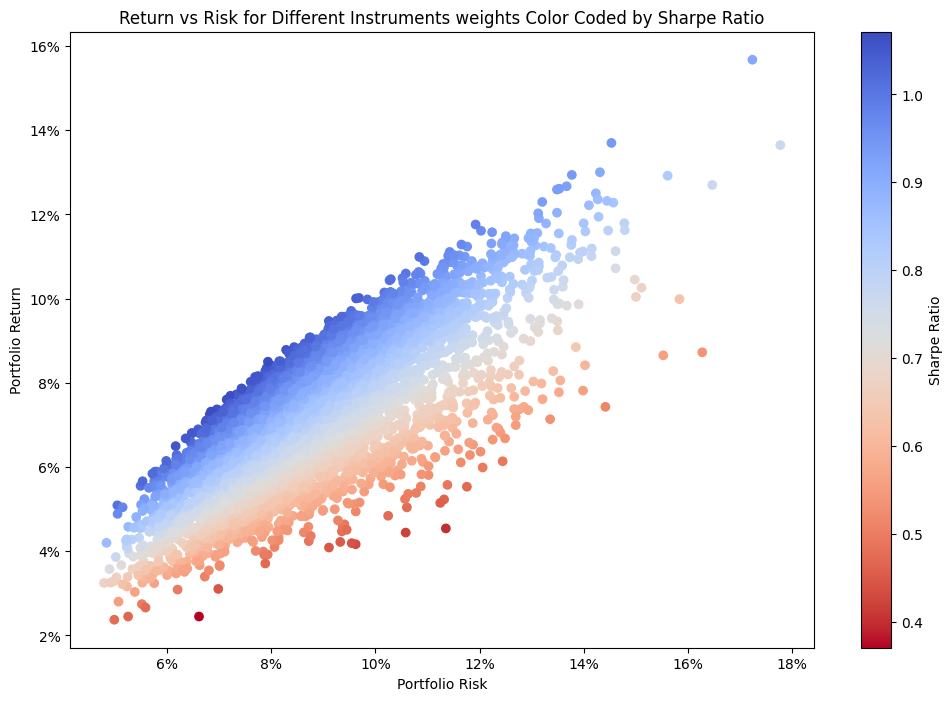

In [19]:
plt.figure(figsize=aspect_ratio)
ax = plt.subplot()

#Plot the reverse colormap
plt.scatter(pvols, prets, c = prets/pvols, marker='o', cmap='coolwarm_r') # prets/pvols gives us the Sharpe of each point
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

# Formatting the axes
plt.title('Return vs Risk for Different Instruments weights Color Coded by Sharpe Ratio')
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Return')

# Add a color bar for Sharpe ratio
plt.colorbar(label='Sharpe Ratio')

## **Minimum Vol Portfolio** 

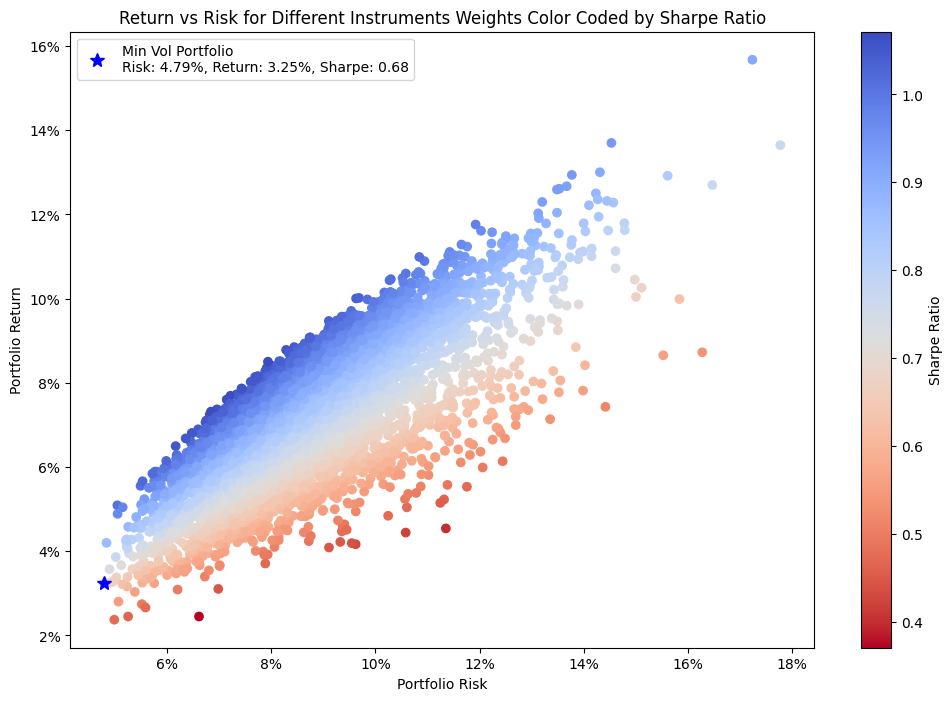

In [20]:
plt.figure(figsize=aspect_ratio)
ax = plt.subplot()

# Plot the reverse colormap
sc = plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='coolwarm_r')  # prets/pvols gives us the Sharpe of each point
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

# Formatting the axes
plt.title('Return vs Risk for Different Instruments Weights Color Coded by Sharpe Ratio')
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Return')
plt.colorbar(sc, label='Sharpe Ratio')  # Add a color bar for Sharpe ratio

# Mark minimum vol portfolio with a markersize=10 with a blue star
min_vol_index = np.argmin(pvols)
min_vol_return = prets[min_vol_index]
min_vol_risk = pvols[min_vol_index]
min_vol_sharpe = prets[min_vol_index] / pvols[min_vol_index]

# Add the point to the plot
plt.plot(min_vol_risk, min_vol_return, 'b*', markersize=10.0, 
         label=f'Min Vol Portfolio\nRisk: {min_vol_risk:.2%}, Return: {min_vol_return:.2%}, Sharpe: {min_vol_sharpe:.2f}')


# Add legend without annotations on the plot
plt.legend()
plt.show()

In [21]:
#Pass the minimum volatility vectors of the portfolios into a dataframe  
df_weights=pd.DataFrame({'Min Vol': min_vol_weights},index=myStrategies)

#Pretty print them 
print_pct_data(df_weights)

,Min Vol
AAPL-MAFlat,0.2625%
AMZN-MAFlat,1.6396%
ATT-BB,15.1275%
GE-MAShort,1.5856%
INTC-BB,4.9211%
FBNDX-MAShort,34.1950%
GOLD-MAShort,13.2417%
EUR-MAShort,29.0269%


Fixed-income instruments, commodities, and currencies receive more weight than tech equities. The following could be plausible reasons for this allocation in a low-volatility portfolio:

* Bonds provide steady income through regular interest payments, contributing to portfolio stability.
* Currency exposure serves as a hedge against domestic currency weakness or economic uncertainties.
* Commodities often perform well during periods of unexpected inflation, which can erode the value of other assets.
* Tech stocks often exhibit higher volatility, which is contrary to the goal of a low volatility portfolio
* Bonds, commodities, and currencies often have a low correlation with stocks, helping to reduce overall portfolio volatility.

## **Maximum Sharpe portfolio**

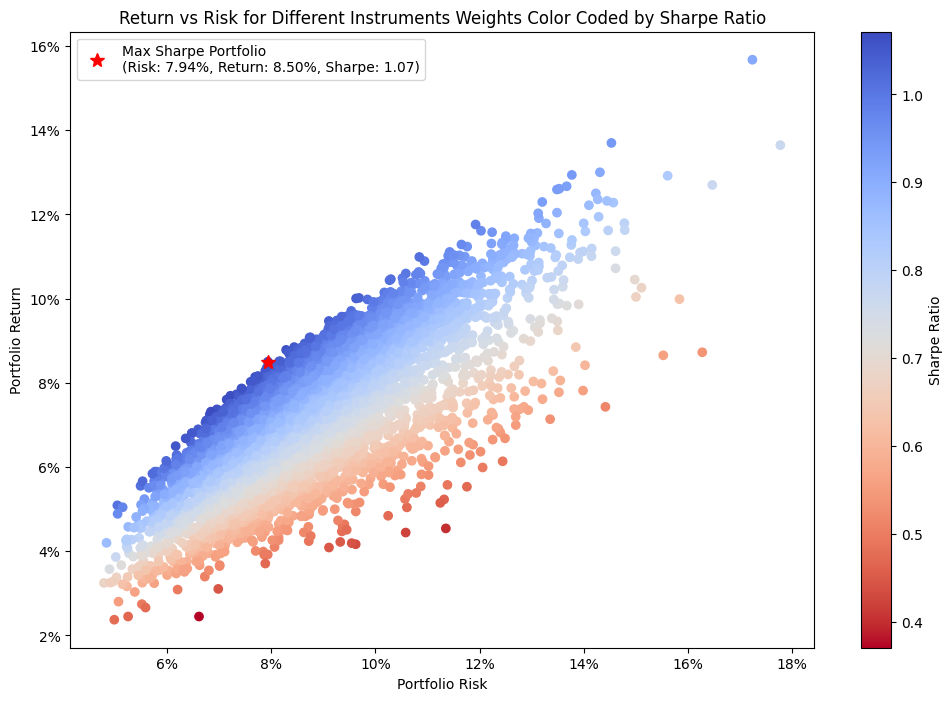

In [22]:
plt.figure(figsize=aspect_ratio)
ax = plt.subplot()

# Plot the reverse colormap
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='coolwarm_r')  # prets/pvols gives us the Sharpe of each point
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

# Formatting the axes
plt.title('Return vs Risk for Different Instruments Weights Color Coded by Sharpe Ratio')
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Sharpe Ratio')  # Add a color bar for Sharpe ratio

# Mark Max Sharpe Portfolio with a markersize=10 with a red star
max_sharpe_index = np.argmax(prets / pvols)
max_sharpe_return = prets[max_sharpe_index]
max_sharpe_risk = pvols[max_sharpe_index]
max_sharpe = prets[max_sharpe_index] / pvols[max_sharpe_index]
# Add the point to the plot
plt.plot(max_sharpe_risk, max_sharpe_return, 'r*', markersize=10.0,
         label=f'Max Sharpe Portfolio\n(Risk: {max_sharpe_risk:.2%}, Return: {max_sharpe_return:.2%}, Sharpe: {max_sharpe:.2f})')

# Add legend without annotations on the plot
plt.legend()
plt.show()


In [23]:
#Pass the maximum sharpe vectors of the portfolios into a dataframe  
df_weights=pd.DataFrame({'Max Sharpe': max_sharpe_weights},index=myStrategies)

#Pretty print them 
print_pct_data(df_weights)

,Max Sharpe
AAPL-MAFlat,22.0730%
AMZN-MAFlat,3.6151%
ATT-BB,17.8950%
GE-MAShort,7.3504%
INTC-BB,1.0917%
FBNDX-MAShort,14.4246%
GOLD-MAShort,6.6239%
EUR-MAShort,26.9264%


Tech equities have more weights allotted over commodities, fixed-income bonds, and currencies in this Max Sharpe portfolio. The following could be the reasons for this allocation:

* Companies like Apple and Amazon are market leaders with strong competitive positions, which may contribute to their favorable risk-return profiles.
* The significant allocations to EUR and FBNDX help balance the portfolio, potentially allowing for higher allocations to riskier tech stocks while maintaining an optimal Sharpe ratio.
* Gold typically has a low correlation with other assets like stocks and bonds, which helps improve the Sharpe ratio.

*Note:* The Sharpe ratio for the maximum sharpe portfolio is greater than the Sharpe from the equal weighted portfolio

## Performance of our Portfolio

In [24]:
#Apply weigths from max sharpe portfolio 
daily_ret = myStratDf.join(pd.DataFrame((max_sharpe_weights * myStratDf).sum(axis=1, skipna=False), columns=['Wtd Daily returns']), how='inner')
daily_ret

,AAPL-MAFlat,AMZN-MAFlat,ATT-BB,GE-MAShort,INTC-BB,FBNDX-MAShort,GOLD-MAShort,EUR-MAShort,Wtd Daily returns
2000-12-13,-0.0,-0.0,0.0,-0.003544,-0.0,0.002809,0.007037,0.002733,0.001347
2000-12-14,-0.0,-0.0,0.0,0.029925,-0.0,0.002801,-0.001857,-0.017295,-0.002176
2000-12-15,-0.0,0.0,-0.0,0.032102,-0.0,0.001398,-0.005180,-0.004807,0.000924
2000-12-18,0.0,-0.0,-0.0,-0.023560,0.0,0.000000,0.002957,0.000669,-0.001356
2000-12-19,-0.0,-0.0,-0.0,0.017306,0.0,-0.001398,-0.000370,0.000782,0.001256
...,...,...,...,...,...,...,...,...,...
2018-12-24,-0.0,-0.0,-0.0,0.032697,-0.0,-0.001303,0.009722,-0.002985,0.002056
2018-12-26,0.0,0.0,0.0,-0.065712,0.0,0.003914,-0.001640,0.004658,-0.003120
2018-12-27,-0.0,-0.0,0.0,0.016371,0.0,0.002618,0.006740,-0.006759,0.000207
2018-12-28,0.0,0.0,0.0,-0.032479,0.0,-0.003924,0.003912,-0.001224,-0.003024


In [25]:
#Calculate performance statistics
calcPerformanceStatistics(daily_ret)

,AAPL-MAFlat,AMZN-MAFlat,ATT-BB,GE-MAShort,INTC-BB,FBNDX-MAShort,GOLD-MAShort,EUR-MAShort,Wtd Daily returns
Average Annual Return,23.5011%,14.1271%,2.6307%,7.9008%,-0.8167%,1.2322%,5.5973%,4.5076%,8.5029%
Annual Risk,28.7634%,35.8873%,15.1716%,31.0465%,12.7071%,3.8187%,17.9483%,10.0701%,7.9367%
Sharpe Ratio,0.817047,0.393651,0.173397,0.254485,-0.064270,0.322663,0.311859,0.447621,1.071346
maxDD,-67.4596%,-71.2899%,-39.6135%,-130.0767%,-52.5385%,-18.9100%,-53.4983%,-20.0057%,-12.5821%
Success Ratio,66.2819%,67.0366%,88.6127%,50.3219%,90.1221%,63.6404%,51.3873%,51.8313%,53.4517%


1. Average Annual Return
* The portfolio's average annual return is 8.50%, higher than lower-performing assets like INTC-BB and ATT-BB. But below top performers AAPL-MAFlat (23.50%) and AMZN-MAFlat (14.13%), indicating a blend of high-performing and lower-returning assets to manage risk.

2. Annual Risk
* With an annual risk of 7.94%, the portfolio is significantly less volatile than high-risk assets like AAPL-MAFlat (28.76%) and AMZN-MAFlat (35.89%), but riskier than safer options like FBNDX-MAShort (3.82%), suggesting a conservative risk profile focused on stability.

3. Sharpe Ratio
* The portfolio's Sharpe Ratio is 1.07, indicating favorable risk-adjusted returns, outperforming many individual assets, especially INTC-BB (-0.06) and GE-MAShort (0.25). A ratio above 1 reflects effective return-to-risk management.

4. Maximum Drawdown (maxDD)
* The maximum drawdown of -12.58% is significantly better than high-risk assets like GE-MAShort (-130.08%) and AAPL-MAFlat (-67.46%), highlighting the portfolio’s resilience and minimizing extreme losses.

5. Success Ratio
* The portfolio's success ratio of 53.45% indicates that just over half of trades were successful, lower than top performers like INTC-BB (90.12%) and ATT-BB (88.61%). Despite this, the asset mix contributes to overall stability and balance between success and risk.

**Beta**

In [26]:
#Join returns of SPY with max sharpe portfolio
betaReturns = master_df[['SPY-BMK-MA']].join (daily_ret[['Wtd Daily returns']], how = 'inner')

#Rename Columns
betaReturns.columns = ['SPY','Port']

#Calculate Beta
port_Reg = sm.OLS(betaReturns.dropna()['Port'], sm.add_constant(betaReturns.dropna()['SPY'])).fit()
port_Reg.params

const    0.000311
SPY      0.121346
dtype: float64

* The intercept value is minute, indicating that even without market movement (SPY return of 0%), the portfolio has a slight positive expected return even when SPY's return is zero.
* For every 1% increase in the return of SPY, the return of the portfolio increases by approximately 0.1213%.
* The maximum Sharpe portfolio is less volatile than SPY and experiences fewer fluctuations than SPY.

## **Variations of Equal Weighted Portfolios**

In [27]:
#Extract BMK values for the chosen instruments from the master dataframe
bmkPortfolio= pd.DataFrame(index= master_df.index)
for x in myStrategies:
    y=x.split('-')[0]
    bmkPortfolio =bmkPortfolio.join(master_df[[f'{y}-BMK-MA']], how ='inner' )
    
#Apply equal weights
equalPort_MA = bmkPortfolio.join(pd.DataFrame((weights * bmkPortfolio).sum(axis=1, skipna=False), columns=['Equal Portfolio']), how='inner')

#Calculate performance statistics
calcPerformanceStatistics(equalPort_MA) 

,AAPL-BMK-MA,AMZN-BMK-MA,ATT-BMK-MA,GE-BMK-MA,INTC-BMK-MA,FBNDX-BMK-MA,GOLD-BMK-MA,EUR-BMK-MA,Equal Portfolio
Average Annual Return,28.6679%,23.4390%,-3.4901%,-11.2112%,1.4506%,0.4376%,8.9723%,1.5317%,6.2247%
Annual Risk,37.1748%,49.8183%,25.4115%,31.0425%,35.3650%,3.8194%,17.9431%,10.0735%,15.9957%
Sharpe Ratio,0.771164,0.470490,-0.137345,-0.361156,0.041018,0.114561,0.500043,0.152056,0.389149
maxDD,-93.8197%,-146.6530%,-103.8316%,-208.1691%,-114.1089%,-23.6986%,-59.0679%,-43.1375%,-59.1298%
Success Ratio,52.3418%,51.6093%,51.7425%,50.0777%,51.6315%,64.6171%,53.0300%,51.2542%,52.5638%


In [28]:
#Extract MAFlat values for the chosen instruments from the master dataframe
maFlatPortfolio= pd.DataFrame(index= master_df.index)
for x in myStrategies:
    y=x.split('-')[0]
    maFlatPortfolio =maFlatPortfolio.join(master_df[[f'{y}-MAFlat']], how ='inner' )

#Apply equal weights
equalPort_MAFlat = maFlatPortfolio.join(pd.DataFrame((weights * maFlatPortfolio).sum(axis=1, skipna=False), columns=['Equal Portfolio']), how='inner')

#Calculate performance statistics
calcPerformanceStatistics(equalPort_MAFlat)

,AAPL-MAFlat,AMZN-MAFlat,ATT-MAFlat,GE-MAFlat,INTC-MAFlat,FBNDX-MAFlat,GOLD-MAFlat,EUR-MAFlat,Equal Portfolio
Average Annual Return,23.5011%,14.1271%,-4.3111%,-1.6552%,1.1840%,0.8349%,7.2848%,3.0197%,5.4982%
Annual Risk,28.7634%,35.8873%,14.7071%,14.8418%,21.2140%,2.7375%,13.3719%,7.0619%,9.3923%
Sharpe Ratio,0.817047,0.393651,-0.293128,-0.111521,0.055812,0.304975,0.544787,0.427601,0.585391
maxDD,-67.4596%,-71.2899%,-82.6868%,-67.9775%,-76.5109%,-13.5158%,-43.0996%,-10.2775%,-21.4607%
Success Ratio,66.2819%,67.0366%,77.2697%,75.0499%,73.9623%,80.4661%,71.8535%,72.8302%,53.9179%


In [29]:
#Extract MAShort values for the chosen instruments from the master dataframe
maShortPortfolio= pd.DataFrame(index= master_df.index)
for x in myStrategies:
    y=x.split('-')[0]
    maShortPortfolio =maShortPortfolio.join(master_df[[f'{y}-MAShort']], how ='inner' )

#Apply equal weights
equalPort_MAShort = maShortPortfolio.join(pd.DataFrame((weights * maShortPortfolio).sum(axis=1, skipna=False), columns=['Equal Portfolio']), how='inner')

#Calculate performance statistics
calcPerformanceStatistics(equalPort_MAShort)

,AAPL-MAShort,AMZN-MAShort,ATT-MAShort,GE-MAShort,INTC-MAShort,FBNDX-MAShort,GOLD-MAShort,EUR-MAShort,Equal Portfolio
Average Annual Return,18.3343%,4.8151%,-5.1320%,7.9008%,0.9174%,1.2322%,5.5973%,4.5076%,4.7716%
Annual Risk,37.1999%,49.8386%,25.4104%,31.0465%,35.3651%,3.8187%,17.9483%,10.0701%,13.6105%
Sharpe Ratio,0.492858,0.096615,-0.201963,0.254485,0.025940,0.322663,0.311859,0.447621,0.350581
maxDD,-108.3666%,-137.5106%,-166.3700%,-130.0767%,-121.5731%,-18.9100%,-53.4983%,-20.0057%,-35.7060%
Success Ratio,52.2087%,50.3219%,50.4772%,50.3219%,51.4095%,63.6404%,51.3873%,51.8313%,51.4983%


In [30]:
#Extract BB values for the chosen instruments from the master dataframe
BBPortfolio= pd.DataFrame(index= master_df.index)
for x in myStrategies:
    y=x.split('-')[0]
    BBPortfolio =BBPortfolio.join(master_df[[f'{y}-BB']], how ='inner' )

#Apply equal weights
equalPort_BB = BBPortfolio.join(pd.DataFrame((weights * BBPortfolio).sum(axis=1, skipna=False), columns=['Equal Portfolio']), how='inner')

#Calculate performance statistics
calcPerformanceStatistics(equalPort_BB)

,AAPL-BB,AMZN-BB,ATT-BB,GE-BB,INTC-BB,FBNDX-BB,GOLD-BB,EUR-BB,Equal Portfolio
Average Annual Return,-9.6856%,-2.8322%,2.6307%,-1.6936%,-0.8167%,-0.1619%,-2.8783%,-1.4099%,-2.1059%
Annual Risk,18.2011%,25.4960%,15.1716%,16.5593%,12.7071%,1.8061%,12.2924%,6.7346%,6.2051%
Sharpe Ratio,-0.532143,-0.111083,0.173397,-0.102275,-0.064270,-0.089636,-0.234149,-0.209348,-0.339386
maxDD,-219.6373%,-138.1841%,-39.6135%,-104.1892%,-52.5385%,-7.7605%,-94.1816%,-38.2723%,-47.2756%
Success Ratio,86.9922%,81.6648%,88.6127%,87.9023%,90.1221%,91.8091%,78.0688%,80.5327%,53.5405%


We can observe that none of the above four portfolios outperform the Sharpe from our maximum portfolio

# Thank you for your time